## Defining Parameters and Detecting Outliers

This report is an exercise in defining the parameters and detecting outliers for a dataset containing information about apartment listings (practice dataset). In this analysis, I mine an archive of sales ads for realty in St. Petersburg, Russia, and the surrounding areas collected over the past few years. Through several rounds of Exploratory Data Analysis, this report is able to determine the market value of real estate properties, define parameters and contribute towards an automated sustem that is capable of detecting anomalies and fraudulent activity. 

### Inspecting Data

Apartment ads are typically laden with details and it takes an expert to quickly sift through ads to find the perfect fit. This dataset is no different, and our goal will be to create insights to provide a real estate agency a description of how different real estate parameters lead to current market values. 

We'll start exploring the data in detail by leveraging pandas. 

In [1]:
# Importing pandas library
import pandas as pd
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder
import ast
import matplotlib.pyplot as plt
import numpy as np
# Connecting data source 
data = pd.read_csv('real_estate_data_us.csv', sep='\t', engine='python')
# Inspecting data 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
date_posted          23699 non-null object
days_listed          20518 non-null float64
last_price           23699 non-null float64
bedrooms             23699 non-null int64
kitchen_area         21421 non-null float64
living_area          21796 non-null float64
total_area           23699 non-null float64
balconies            12180 non-null float64
ceiling_height       14504 non-null float64
floors_total         23613 non-null float64
floor                23699 non-null int64
total_images         23699 non-null int64
bike_parking         2775 non-null object
is_studio            23699 non-null bool
is_open_plan         23699 non-null bool
locality_name        23650 non-null object
airport_dist         18157 non-null float64
city_center_dist     18180 non-null float64
park_dist            8079 non-null float64
parks_within_3000    18181 non-null float64
pond_dist            9110 no

In [2]:
data.head()

,date_posted,days_listed,last_price,bedrooms,kitchen_area,living_area,total_area,balconies,ceiling_height,floors_total,...,bike_parking,is_studio,is_open_plan,locality_name,airport_dist,city_center_dist,park_dist,parks_within_3000,pond_dist,ponds_within_3000
0,2019-03-07T00:00:00,NaN,260000.0,3,25.0,51.0,108.0,NaN,2.70,16.0,...,NaN,False,False,Saint Petersburg,18863.0,16028.0,482.0,1.0,755.0,2.0
1,2018-12-04T00:00:00,81.0,67000.0,1,11.0,18.6,40.4,2.0,NaN,11.0,...,NaN,False,False,Shushary village,12817.0,18603.0,NaN,0.0,NaN,0.0
2,2015-08-20T00:00:00,558.0,103920.0,2,8.3,34.3,56.0,0.0,NaN,5.0,...,NaN,False,False,Saint Petersburg,21741.0,13933.0,90.0,1.0,574.0,2.0
3,2015-07-24T00:00:00,424.0,1298000.0,3,NaN,NaN,159.0,0.0,NaN,14.0,...,NaN,False,False,Saint Petersburg,28098.0,6800.0,84.0,2.0,234.0,3.0
4,2018-06-19T00:00:00,121.0,200000.0,2,41.0,32.0,100.0,NaN,3.03,14.0,...,NaN,False,False,Saint Petersburg,31856.0,8098.0,112.0,2.0,48.0,1.0


### Conclusion

By exploring the column names and data types we see that a majority of the data show what apartment have to offer. We also have available to us the rent amount, which will help us to provide a meaningful metric to the real estate agency. We also can look forward to exploring potential linear or other relationships between different apartment features and the rent amount and how long the apartment has been available. 

### Data preprocessing

We definitely want to make sure we are prepping this dataset with as much detail as possible. We know the saying, "Garbage in, garbage out" and so we'll want to make sure to get rid of the garbage. If we happen to come across data we have questions about and that impede our preprocessing, we'll leave it untouched until we can speak further with the real estate agency and sort out any questions. For the moment though, it looks like we have a lot of work ahead of us. 

When we encounter new datasets and data sources, as is the case here, it is important to sift through the data and look for missing values. Some missing values may be missing at random (MAR), missing completely at random (MCAR) or missing not at random (MNAR). 

#### Missing Values

In order to check for missing values such as NaN and None values, we can employ two different methods. One method uses value_counts() and the other uses isnull() to check for missing values. We could use both or one, and today we'll be using both. 

We'll start by using the value_counts() method and isnull() later on. By using value_count(), we'll also get a head start on identifying duplicate values and noticing patterns in the data. 

In [3]:
# Exploring columns, looking for missing values, getting to know the data with value_counts()
# print(data['date_posted'].value_counts())
# print(data['days_listed'].value_counts())
# print(data['days_listed'].value_counts())
# ...

Using value_counts, we didn't detect any None values. However we will also use isnull to look for any cells that are missing data altogether. Once we spot any missing values, we'll want to make a decision about how to fill these or perhaps leave them untouched, or also delete the rows altogether. We will be picking between leaving them blank or using the column mean or median. 

In [4]:
# Looking for missing values using isnull()
print(data.columns[data.isnull().any()])

Index(['days_listed', 'kitchen_area', 'living_area', 'balconies',
       'ceiling_height', 'floors_total', 'bike_parking', 'locality_name',
       'airport_dist', 'city_center_dist', 'park_dist', 'parks_within_3000',
       'pond_dist', 'ponds_within_3000'],
      dtype='object')


It is interesting to note that the last 6 of the missing values are not errors from users who input the information. The real estate agency let us know that this is data that was calculated automatically based upon the map data. This includes distance from the city center, the airport, and the nearest park or body of water. Let's continue to look for any patterns in the missing data, to ask ourselves what types of errors exist in the data entry. To do this, we'll start by viewing just the cells with missing values using filter().  

In [5]:
# Looking for any connections between missing data
data_subset = data.filter(['days_listed', 'kitchen_area', 'living_area',
       'ceiling_height', 'floors_total', 'locality_name', 'airport_dist',
       'city_center_dist', 'park_dist', 'parks_within_3000', 'pond_dist',
       'ponds_within_3000'], axis = 1)
data_subset.head(5)

,days_listed,kitchen_area,living_area,ceiling_height,floors_total,locality_name,airport_dist,city_center_dist,park_dist,parks_within_3000,pond_dist,ponds_within_3000
0,NaN,25.0,51.0,2.70,16.0,Saint Petersburg,18863.0,16028.0,482.0,1.0,755.0,2.0
1,81.0,11.0,18.6,NaN,11.0,Shushary village,12817.0,18603.0,NaN,0.0,NaN,0.0
2,558.0,8.3,34.3,NaN,5.0,Saint Petersburg,21741.0,13933.0,90.0,1.0,574.0,2.0
3,424.0,NaN,NaN,NaN,14.0,Saint Petersburg,28098.0,6800.0,84.0,2.0,234.0,3.0
4,121.0,41.0,32.0,3.03,14.0,Saint Petersburg,31856.0,8098.0,112.0,2.0,48.0,1.0


We'll tackle missing values in two ways. One, for values that we cannot fill using a central tendency value or other value, we will delete their corresponding rows altogether. Secondly, for values where we can safely make assumptions about how to fill these (I.e., blank balcony data indicates no balcony offered in the apartment), we will go ahead and fill the cells appropriately. 

#### Replacing Missing Values

In [6]:
# Replacing the missing values in the balconies column with 0 
# Since this data set is partly built with user-input information, no balcony data likely means there is no balcony 
data['balconies'] = data['balconies'].fillna(value = 0)

In [7]:
# Replacing missing values in the bike column with False 
data['bike_parking'] = data['bike_parking'].fillna(value = False)

In [8]:
# We can't fill locality name based on other data, but we also don't want to get rid of the data 
    # So we will replace missing values in this column with the value "Unknown"
data['locality_name'] = data['locality_name'].fillna(value = 'Unknown')

In [9]:
# Replacing missing values in the following column with the column average 
# Creating representative values first 
days_listed_avg = data['days_listed'].mean()
data['days_listed'] = data['days_listed'].fillna(value = days_listed_avg)

In [10]:
# Replacing missing values in the following column with the column average 
# Creating representative values first 
ceiling_height_avg = data['ceiling_height'].mean()
data['ceiling_height'] = data['ceiling_height'].fillna(value = ceiling_height_avg)

In [11]:
# Replacing missing values in the following column with the column average 
# Creating representative values first 
floors_total_avg = data['floors_total'].mean()
data['floors_total'] = data['floors_total'].fillna(value = floors_total_avg)

In [12]:
# Replacing missing values in the following column with the column average 
# Creating representative values first 
airport_dist_avg = data['airport_dist'].mean()
data['airport_dist'] = data['airport_dist'].fillna(value = airport_dist_avg)

In [13]:
# Replacing missing values in the following column with the column average 
# Creating representative values first 
city_center_dist_avg = data['city_center_dist'].mean()
data['city_center_dist'] = data['city_center_dist'].fillna(value = city_center_dist_avg)

In [14]:
# Replacing missing values in the following column with the column average 
# Creating representative values first 
park_dist_avg = data['park_dist'].mean()
data['park_dist'] = data['park_dist'].fillna(value = park_dist_avg)

In [15]:
# Replacing missing values in the following column with the column average 
# Creating representative values first 
parks_within_3000_avg = data['parks_within_3000'].mean()
data['parks_within_3000'] = data['parks_within_3000'].fillna(value = parks_within_3000_avg)

In [16]:
# Replacing missing values in the following column with the column average 
# Creating representative values first 
pond_dist_avg = data['pond_dist'].mean()
data['pond_dist'] = data['pond_dist'].fillna(value = pond_dist_avg)

In [17]:
# Replacing missing values in the following column with the column average 
# Creating representative values first 
ponds_within_3000_avg = data['ponds_within_3000'].mean()
data['ponds_within_3000'] = data['ponds_within_3000'].fillna(value = ponds_within_3000_avg)

#### Deleting Rows With Missing Values

There will also inevitably be values that we can't fill, because we don't have enough information about what to fill them with. For these, we will go ahead and delete their corresponding rows altogether: 

In [18]:
# Counting how many rows we have before deleting rows
print(len(data))

23699


In [19]:
# We are deleting 'kitchen_area' and 'living_area' because there is no sure way of knowing 
    # if a missing value is a typo or if it means the apartment doesn't offer these 
data = data.dropna(subset = ['kitchen_area', 'living_area'])

In [20]:
# Counting how many rows we have after deleting the rows with missing values 
print(len(data))

20982


#### Correcting Data Types

We're seeing a couple of wrong data types. Let's correct them before moving forward. The data types we're changing are: 

- date_posted so that we can use other functions on this column
- bike_parking to boolean, again so that we can make calculation on this value

There isn't currently an identified need to change the following values to integers, however we may circle back to this decision later on: days_listed, last_price, balconies, floors_total. These could be set to integers instead of floats, since we wouldn't need decimals and long numbers to gain an accurate understanding of these values. 

In [21]:
# Changing date_posted to date and time data type 
data['date_posted'] = pd.to_datetime(data['date_posted'], format = '%Y-%m-%dT%H:%M:%S')

In [22]:
# Changing bike_parking to boolean 
data['bike_parking'] = data['bike_parking'].astype(bool)

### Conclusion

This deep dive showed us a lot about the data! We saw that several columns have the wrong data type, and more interestingly we saw that some of the columns had outliers. Some apartments have been on the market for a lot longer than others, and some apartments are part of impressive 60 floors complexes, while others are in more conservative 5 floor buildings. 

By using isnull() we were also able to spot where there were missing values and replace these with their appropriate value. We also took this time to correct the wrong data types. We can now feel comfortable to begin analyzing these apartment ads. 

### Adding Calculations

Now that we've cleaned up our data, let's move onto adding a few more insightful pieces. We have a lot of great numbers and information about apartment features. Let's dive in to see how these features relate to each other. For example, we'll start off by analyzing how large of an apartment a potential client could expect to rent given their budget. 

In [23]:
# Calculating and adding to the table: the price per square meter
data['price_per_sqmeter'] = data['last_price']/data['total_area']
print(data['price_per_sqmeter'].head())
print(data['price_per_sqmeter'].mean())

0    2407.407407
1    1658.415842
2    1855.714286
4    2000.000000
5    1901.315789
Name: price_per_sqmeter, dtype: float64
1984.0625539953558


In [24]:
# Calculating and adding to the table: 
            # the day of the week the ad was published
data['date_posted_week'] = data['date_posted'].dt.dayofweek
print(data['date_posted_week'].head())

0    3
1    1
2    3
4    1
5    0
Name: date_posted_week, dtype: int64


In [25]:
# Calculating and adding to the table: 
            # the month that the ad was published
data['date_posted_month'] = data['date_posted'].dt.month
print(data['date_posted_month'].head())

0     3
1    12
2     8
4     6
5     9
Name: date_posted_month, dtype: int64


In [26]:
# Calculating and adding to the table: 
            # the year that the ad was published
data['date_posted_year'] = data['date_posted'].dt.year
print(data['date_posted_year'].head())

0    2019
1    2018
2    2015
4    2018
5    2018
Name: date_posted_year, dtype: int64


You should do next fixes:
instead of data['floor'].apply(floor_tracker) you should use data.apply(floor_tracker, axis=1)
in the function floor_tracker you should change floor_tracker(floor) to floor_tracker(row) and use row['floor'] instead of floor and row['floors_total'] instead of data['floors_total']

In [27]:
# Calculating and adding to the table: which floor the apartment is on (first, last, or other)

# Creating a function to floors by their position relative to the total floors in the apartment building 
def floor_tracker(row):
    if row['floor'] <= 1:
        return 'first'
    if row['floor'] == row['floors_total']:
        return 'last'
    if row['floor'] >= 2:
        return 'other'

# Creating a new column called floor_position 
# Applying the floor_tracker to the floor column 
data['floor_position'] = data.apply(floor_tracker, axis=1)

print(data['floor_position'].value_counts())

other    15427
last      2995
first     2560
Name: floor_position, dtype: int64


In [28]:
# Calculating and adding to the table: the ratio between the living space and the total area
data['living_to_totalarea'] = data['living_area']/data['total_area']
print(data['living_to_totalarea'].head())

0    0.472222
1    0.460396
2    0.612500
4    0.320000
5    0.473684
Name: living_to_totalarea, dtype: float64


In [29]:
# Calculating and adding to the table: the ratio between the kitchen space and the total area
data['kitchen_to_totalarea'] = data['kitchen_area']/data['total_area']
print(data['kitchen_to_totalarea'].head())

0    0.231481
1    0.272277
2    0.148214
4    0.410000
5    0.299342
Name: kitchen_to_totalarea, dtype: float64


### Exploratory Data Analysis

#### Analyzing Apartment Features with Histograms

Our real estate agency client is looking to gain insight regarding the market value of apartments based on their distinct features, like size (square area), price, number of rooms and ceiling height. We'll start by using histograms to show what types of apartments this real estate agency has represented in the past. Sort_values() and value_counts() will help us to gain a better understanding on how to set our bin size and range so that we're not throwing arrows in the dark. 

In [30]:
# data.sort_values(by = 'total_area')
# data.sort_values(by = 'last_price')
# data.sort_values(by = 'bedrooms')
# data.sort_values(by = 'ceiling_height')

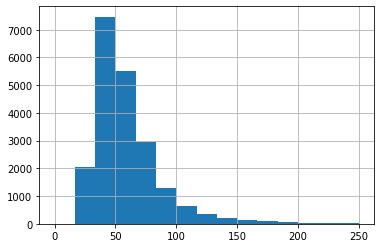

In [31]:
# Plotting a histogram for the total apartment area (square meters)
data['total_area'].hist(bins = 15, range = (0, 250))
plt.show()

The histogram shows us that a majority of apartment advertisements list a total area of 40 to 50 square meters. We also saw that a couple of outliers existed that listed their total area as above 250 square meters and up to 900 square meters. We adjusted the range to reflect a more accurate picture of the distribution. We also see that many apartments list a very low total area, this could indicate that the listings are actually rooms for rent, instead of apartments. 

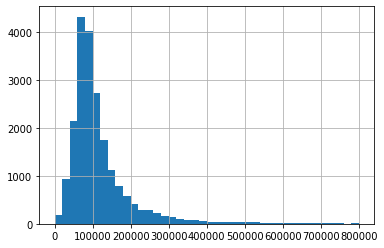

In [32]:
# Plotting a histogram for the apartment price
data['last_price'].hist(bins = 40, range = (0, 800000))
plt.show()

We see more outliers here, as the distribution typically ends at an apartment price of $800000. We adjusted the range accordingly. We also observe some apartments that were offered at a very low price, this is suspicious and most likely can point to fraudulent advertising listings. 

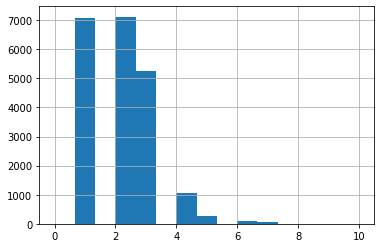

In [33]:
# Plotting a histogram for the number of rooms
data['bedrooms'].hist(bins = 15, range = (0, 10))
plt.show()

We also cutt off some outliers here and are starting to get a better sense of the apartment listings. We see that there are listings which point to 0 bedrooms, this could indicate that they are studio apartments where there is no specifically designated bedroom. 

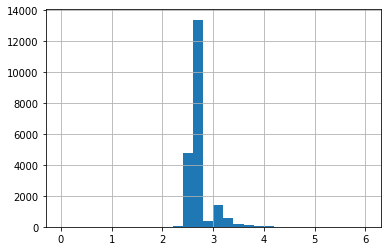

In [34]:
# Plotting a histogram for the ceiling height
data['ceiling_height'].hist(bins = 30, range = (0, 6))
plt.show()

We also cut off some outliers here and adjusted our range to end at 6 meters. But overall, it makes sense that ceiling height has the least widely spread out data. Most apartment buildings tend to share similar ceiling height. 

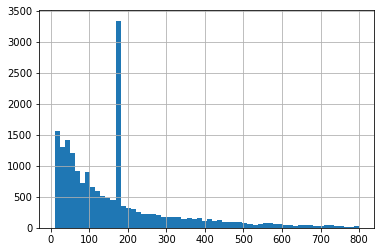

In [35]:
# Plotting a histogram for the days_listed
data['days_listed'].hist(bins = 60, range = (10, 800))
plt.show()

That's interesting: There's a good chuck of advertisements that stand out at having been listed for a little over 150 days. It's a deviation from our distribution, as can be observed above. I would be interested in taking a look at what these records share in common other than days listed, but for the purpose of this analysis and since we're looking at the dataset overall, we'll want to delete these outliers shortly. 

#### When can a sale be considered extra quick or taking an extra slow?

In order to answer this question, we'll first examine the time it's taking to sell an apartment. We'll use both a histogram and also calculate the mean and median to explain the average time it usually takes to complete a sale.

In [36]:
# Finding out the average time it usually takes to complete a sale 
listing_mean = round(data['days_listed'].mean())
listing_median = round(data['days_listed'].median())
print('The average time it usually takes to complete a sale is:', listing_mean, 'days')
print('The median time it usually takes to complete a sale is:', listing_median, 'days')

The average time it usually takes to complete a sale is: 185 days
The median time it usually takes to complete a sale is: 133 days


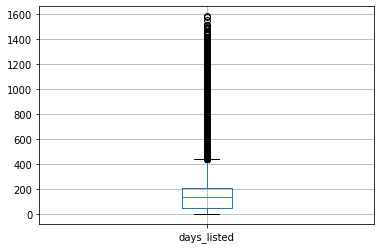

In [37]:
# Building a boxplot to assess the distribution
data.boxplot(column = 'days_listed')
# print(boxplot)
plt.show()

In [38]:
print(round(np.percentile(data.days_listed, 25)), 'days listed')  # Q1

48.0 days listed


In [39]:
print(round(np.percentile(data.days_listed, 50)), 'days listed') # median

133.0 days listed


In [40]:
print(round(np.percentile(data.days_listed, 75)), 'days listed') # Q3

205.0 days listed


When can a sale be considered extra quick or taking an extra slow? By looking at our visualization above, we could make a statement relative to the first and third quartiles. They mark the distance from the median, or the second quartile. We could point out that: 

- Listings that are active for 48 days or less can be considered as quick sales
- Listings that are active for 205 days or more can be considered as slow sales

#### Removing outliers

We had to adjust the range from every single visualization above meaning there is a lot of outliers in this dataset. We could easily attribute this to errors from the users to input the data and it also could be worth taking a look at how the computer draws the information regarding distance automatically. In any case, it's best to remove outliers, especially from the columns we'll be analyzing consequently, so that we can have clean and accurate visualizations and calculations. We'll go ahead and remove rare and outlying values from all columns below. 

In [41]:
print(len(data))

20982


In [42]:
# Removing outliers from total_area

# Calculating z-scores for dataframe 'data'
z_score = stats.zscore(data['total_area'])
# Converting each element to its absolute value 
abs_z_score = np.abs(z_score)
# Create a boolean array 
filtered_total_area = (abs_z_score < 3)
# Filtering the original dataframe with this result 
data = data[filtered_total_area]

In [43]:
# Removing outliers from last_price

# Calculating z-scores for dataframe 'data'
z_score_2 = stats.zscore(data['last_price'])
# Converting each element to its absolute value 
abs_z_score_2 = np.abs(z_score_2)
# Create a boolean array 
filtered_last_price = (abs_z_score_2 < 3)
# Filtering the original dataframe with this result 
data = data[filtered_last_price]

In [44]:
# Removing outliers from bedrooms 

# Calculating z-scores for dataframe 'data'
z_score_3 = stats.zscore(data['bedrooms'])
# Converting each element to its absolute value 
abs_z_score_3 = np.abs(z_score_3)
# Create a boolean array 
filtered_bedrooms = (abs_z_score_3 < 3)
# Filtering the original dataframe with this result 
data = data[filtered_bedrooms]

In [45]:
# Removing outliers from ceiling_height

# Calculating z-scores for dataframe 'data'
z_score_4 = stats.zscore(data['ceiling_height'])
# Converting each element to its absolute value 
abs_z_score_4 = np.abs(z_score_4)
# Create a boolean array 
filtered_ceiling_height = (abs_z_score_4 < 3)
# Filtering the original dataframe with this result 
data = data[filtered_ceiling_height]

In [46]:
# Removing outliers from days_listed

# Calculating z-scores for dataframe 'data'
z_score_5 = stats.zscore(data['days_listed'])
# Converting each element to its absolute value 
abs_z_score_5 = np.abs(z_score_5)
# Create a boolean array 
filtered_days_listed = (abs_z_score_5 < 3)
# Filtering the original dataframe with this result 
data = data[filtered_days_listed]

In [47]:
print(len(data))

19546


#### Analyzing Correlations With Scatterplots

Which factors have had the biggest influence on an apartment’s price? We will now examine whether the value depends on the total square area, number of rooms, floor (top or bottom), or the proximity to the city center area. We will also be checking whether the publication date has any effect on the price: specifically, day of the week, month, and year. 

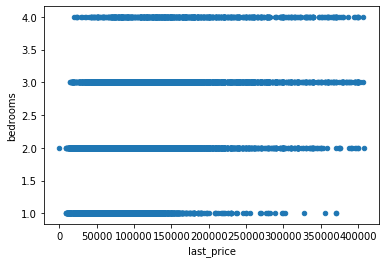

0.46556620972437396


In [48]:
# Creating a scatterplot to show relationship between price and number of rooms
data.plot(x = 'last_price', y = 'bedrooms', kind = 'scatter')
plt.show()
print(data['last_price'].corr(data['bedrooms']))

In [49]:
data['floor_position'].value_counts()

other    14395
last      2736
first     2415
Name: floor_position, dtype: int64

In [50]:
# Transforming floor_position object type into numeric

In [51]:
enc = OrdinalEncoder()

In [52]:
data[["floor_position"]] = enc.fit_transform(data[["floor_position"]])


In [53]:
data['floor_position'].value_counts()

2.0    14395
1.0     2736
0.0     2415
Name: floor_position, dtype: int64

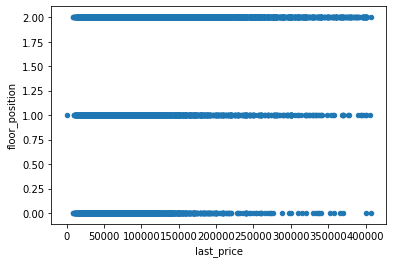

0.14506821159635555


In [54]:
# Creating a scatterplot to show relationship between price and floor position
data.plot(x = 'last_price', y = 'floor_position', kind = 'scatter')
plt.show()
print(data['last_price'].corr(data['floor_position']))

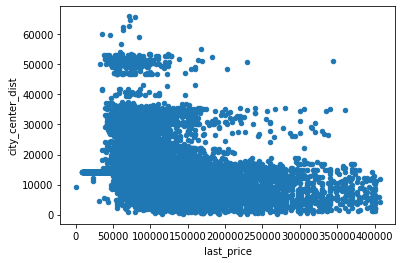

-0.2940477139268287


In [55]:
# Creating a scatterplot to show relationship between price and proximity to the city center
data.plot(x = 'last_price', y = 'city_center_dist', kind = 'scatter')
plt.show()
print(data['last_price'].corr(data['city_center_dist']))

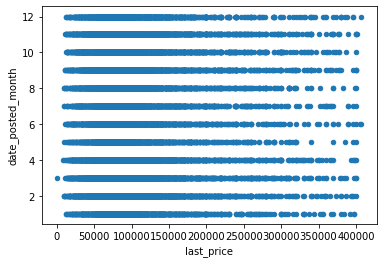

0.008290201486651983


In [56]:
# Creating a scatterplot to show relationship between price and publication month
data.plot(x = 'last_price', y = 'date_posted_month', kind = 'scatter')
plt.show()
print(data['last_price'].corr(data['date_posted_month']))

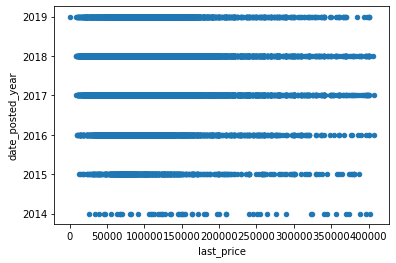

-0.000431437956959544


In [57]:
# Creating a scatterplot to show relationship between price and publication year 
data.plot(x = 'last_price', y = 'date_posted_year', kind = 'scatter')
plt.show()
print(data['last_price'].corr(data['date_posted_year']))

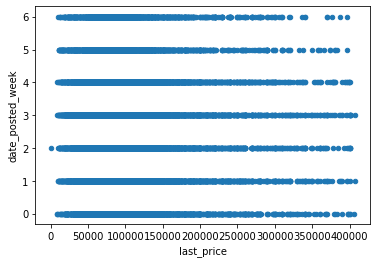

-0.012063221239714738


In [58]:
# Creating a scatterplot to show relationship between price and publication day of the week
data.plot(x = 'last_price', y = 'date_posted_week', kind = 'scatter')
plt.show()
print(data['last_price'].corr(data['date_posted_week']))

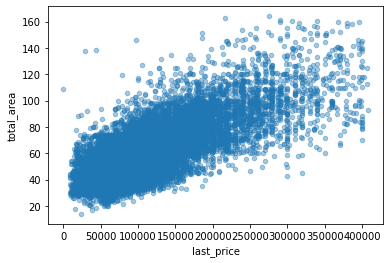

0.7628737166442969


In [59]:
# Creating a scatterplot to show relationship between price and total square area 
data.plot(x = 'last_price', y = 'total_area', kind = 'scatter', alpha = .4)
plt.show()
print(data['last_price'].corr(data['total_area']))

We're seeing a couple different distributions but the only relationship we can observe is between the total area of an apartment and its value. The scatterplot for these two variables shows a positive correlations. We can discuss the relationship numerically, by drawing the Pearson correlation coefficient. 

In [60]:
print(data['total_area'].corr(data['last_price']))

0.762873716644297


The Pearson correlation coefficient shoes there is a positive relationship, as the second value grows, so does the first. The coefficient inches towards 1 and shows that indeed, the real estate market is generally providing buyers more space for their buck. 

#### Housing Prices by Locality

Select the 10 localities with the largest number of ads then calculate the average price per square meter in these localities. Determine which ones have the highest and lowest housing prices. You can find this data by name in the ’locality_name’ column.


In [61]:
# Finding top 10 most recurring localities
data['locality_name'].value_counts().head(10)

Saint Petersburg     12859
Murino village         418
Shushary village       385
Vsevolozhsk            347
Kolpino                315
Pushkin                314
Pargolovo village      283
Gatchina               280
Kudrovo village        218
Vyborg                 181
Name: locality_name, dtype: int64

In [62]:
# Query for a new dataframe that only has the top 10 most recurring localities
data_top10 = data.query('locality_name in ("Saint Petersburg", "Murino village", "Shushary village", "Vsevolozhsk", "Pushkin", "Kolpino", "Gatchina", "Pargolovo village", "Kudrovo village", "Petergof")') 

In [63]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
# Calculating and adding to the table: the price per square meter
data_top10['top10_price_per_sqmeter'] = data_top10['last_price']/data_top10['total_area']
print(data_top10['top10_price_per_sqmeter'].head())

0    2407.407407
1    1658.415842
2    1855.714286
4    2000.000000
6    1983.914209
Name: top10_price_per_sqmeter, dtype: float64


In [65]:
# Average price per square meter in these localities
data_top10['top10_price_per_sqmeter'].mean()

2076.3779681051733

In [66]:
# Showing locality (I couln't figure out how to view it)
data_top10['locality_show'] = data_top10['locality_name']

In [67]:
# Grouping top 10 most recurring localities and showing their average price per square meter
data_top10.groupby('locality_name')['top10_price_per_sqmeter'].mean()

locality_name
Gatchina             1375.468375
Kolpino              1503.164226
Kudrovo village      1846.098642
Murino village       1714.047180
Pargolovo village    1813.079773
Petergof             1667.273126
Pushkin              2040.450889
Saint Petersburg     2168.575239
Shushary village     1569.439305
Vsevolozhsk          1348.747477
Name: top10_price_per_sqmeter, dtype: float64

#### Costliest Cities 
By grouping our values and then looking for their average price per square meter, we see that Saint Petersburg has the costliest options at 2278 per square meter. 

#### More Economic Living Options

Using this same logic, we see that Gatchina has the most economic options at 1373 per square meter. This town is followed closely by Vsevolozhsk where we can find apartments that average at 1381 per square meter. 

#### Finding the City Center

We're curious to examine what, if any, differences exist for apartments that are located in the city center. Before diving in to more plots and graphs, we first have to identiy the city center. Although we know that Saint Petersburg is the main city, we still don't know how large the city center radius is. 

To find the radius, we'll plot the apartment's distance to the city center against their prices. Our reasoning here is that the most expensive apartments will be listed within the city center. 

We'll start by selecting apartments in Saint Petersburg, calculating the average price for each kilometer and plotting a graph to display how prices are affected by the distance to the city center.

In [68]:
# Creating a column with the distance to the city center in km 
    # and rounding to the nearest whole number
data['km_dist'] = data['data_stpetersburg'] = (data["city_center_dist"] / 1000).round()

In [69]:
# Calculating the average price for each kilometer
km_price = data[data.locality_name == "Saint Petersburg"].groupby("km_dist")["last_price"].mean()

<BarContainer object of 30 artists>

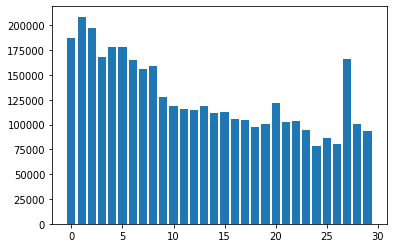

In [70]:
# Plotting a graph to display how prices are affected by the distance to the city center
plt.bar(km_price.index, km_price.values)

By using a bar chart to examine the distribution of ads based off of their distance to the city center, we're able to see a drop in ads for apartments which are located past 8 kilometers. We'll understand this to be the borders of the city center. 

#### Analyzing Correlations

Let's jump in to examining the apartments listed in the city center. Similar to our previous analysis, we'll examine correlations between the following parameters: total area, price, number of rooms, ceiling height. We will also identify the factors that affect an apartment’s price: number of rooms, floor, distance to the city center, and ad publication date.

In [71]:
# Query for a new dataframe that only has the ads listed within 8 km of city center
city_center = data.query('km_dist < 8.0') 

In [72]:
print(len(city_center))

2358


In [73]:
# Examining correlations between the following parameters:
    # total area, price, number of rooms, ceiling height.
    
# Creating a new dataframe with specific columns so we can do a scatter matrix on them
scatter_city_center = city_center.filter(['total_area', 'last_price', 'bedrooms', 'ceiling_height'], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20e69d50>,
      dtype=object)

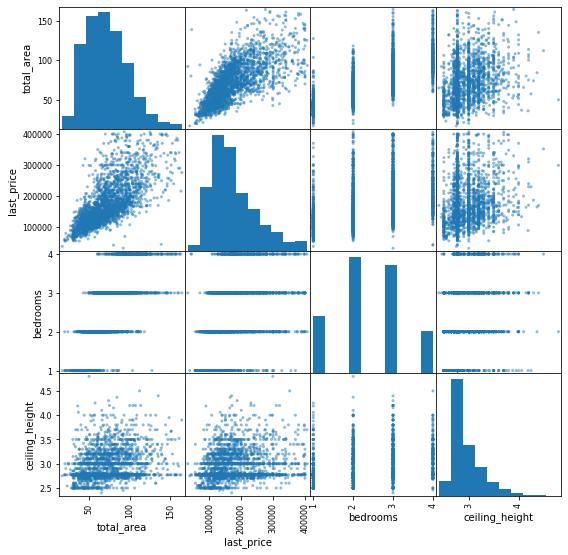

In [74]:
# Building pairwise scatter plots for the scatter_city_center columns 
pd.plotting.scatter_matrix(scatter_city_center, figsize=(9, 9))

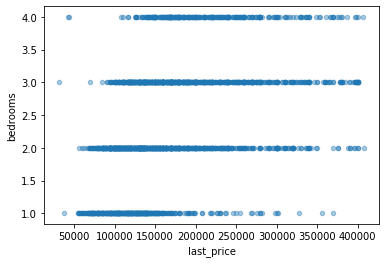

0.41161650787733767


In [75]:
# Creating a scatterplot to show relationship between price and bedrooms
city_center.plot(x = 'last_price', y = 'bedrooms', kind = 'scatter', alpha = .4)
plt.show()
print(city_center['last_price'].corr(city_center['bedrooms']))

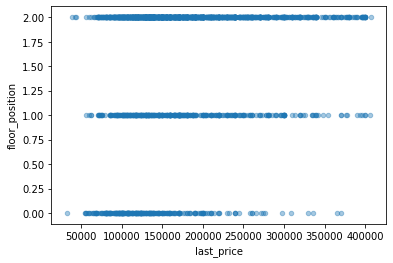

0.1979663579064274


In [76]:
# Creating a scatterplot to show relationship between price and floor_position
city_center.plot(x = 'last_price', y = 'floor_position', kind = 'scatter', alpha = .4)
plt.show()
print(city_center['last_price'].corr(city_center['floor_position']))

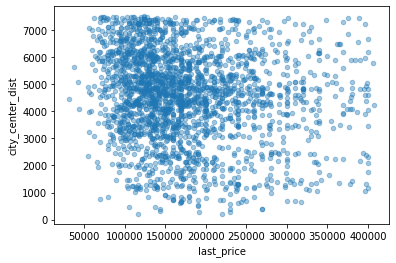

-0.14748567766445736


In [77]:
# Creating a scatterplot to show relationship between price and city_center_dist
city_center.plot(x = 'last_price', y = 'city_center_dist', kind = 'scatter', alpha = .4)
plt.show()
print(city_center['last_price'].corr(city_center['city_center_dist']))

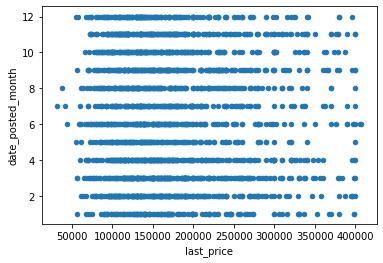

-0.01796162835235078


In [78]:
# Creating a scatterplot to show relationship between price and publication month
city_center.plot(x = 'last_price', y = 'date_posted_month', kind = 'scatter')
plt.show()
print(city_center['last_price'].corr(city_center['date_posted_month']))

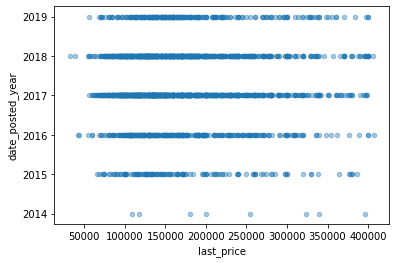

0.0057861512461125555


In [79]:
# Creating a scatterplot to show relationship between price and publication year
city_center.plot(x = 'last_price', y = 'date_posted_year', kind = 'scatter', alpha = .4)
plt.show()
print(city_center['last_price'].corr(city_center['date_posted_year']))

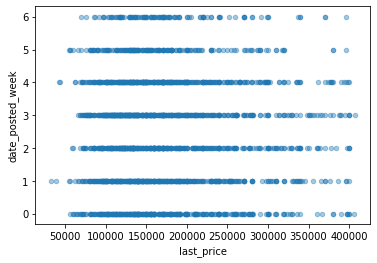

-0.0046673858083297


In [80]:
# Creating a scatterplot to show relationship between price and publication day of the week
city_center.plot(x = 'last_price', y = 'date_posted_week', kind = 'scatter', alpha = .4)
plt.show()
print(city_center['last_price'].corr(city_center['date_posted_week']))

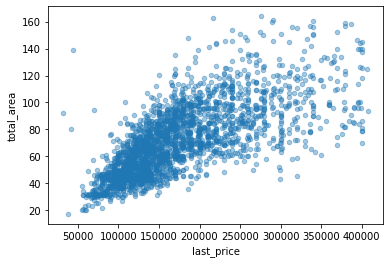

0.7046857776701763


In [81]:
# Creating a scatterplot to show relationship between price and total_area
city_center.plot(x = 'last_price', y = 'total_area', kind = 'scatter', alpha = .4)
plt.show()
print(city_center['last_price'].corr(city_center['total_area']))

### General Conclusion

We recommend that the real estate agency build an automated system based off of the typical apartment features we see across the majority of their listings. By continuing to periodically analyze the parameters, the real estate agency will be able to recognize fraudulent activity and detect anomalies. By defining parameters, the agency will also be able to help clients and renters find what they're looking for. 

We've learned a lot about what typical apartments listed by this real estate agency look like. The plots above show us which variables are prone to having outliers, and we recommend that the agency be able to place new listings under review if they fall beyond one or two standard deviations. The boundaries can be decided by the agency and can differ for each parameters. 

We also found a positive correlation between total area of an apartment and price. This is a useful marker that we can use to continue looking for in all apartments. For example, advertisements listing very small apartments for a high cost, can be indicative of an issue. 

We also recommend the real estate agency create a search engine with specific filters for location, and specifying listings for apartments in the city center. As shows in the bar graph above, there is a noticeable drop in price when apartments are listed as located 8 kilometers beyond the city center. Those searching using price filters, may be looking for an apartment whose value is not increased by its proximity to the city center. This could be true for others seeking an apartment with the real estate agency. 

We also recommend that the agency pull listings for review that have been listed for longer than 205 days. These advertisements may be fraudulent or could simply use better pictures, more information, etc. 